### **Preparation du fichier / Analyse**

In [ ]:
import pandas as pd


df = pd.read_csv("ASTD_RAW.csv", encoding="utf-8")

# Find the number of duplicate rows based on the 'Text' column
duplicates_count = df.duplicated(subset="Text").sum()

# Remove duplicate rows based on the 'Text' column
df = df.drop_duplicates(subset="Text", keep="first")

# Print the results
print(f"{duplicates_count} duplicate rows were deleted.")

4 duplicate rows were deleted.


Sentiment Distribution:
 Label
OBJ        6466
NEG        1642
NEUTRAL     805
POS         777
Name: count, dtype: int64


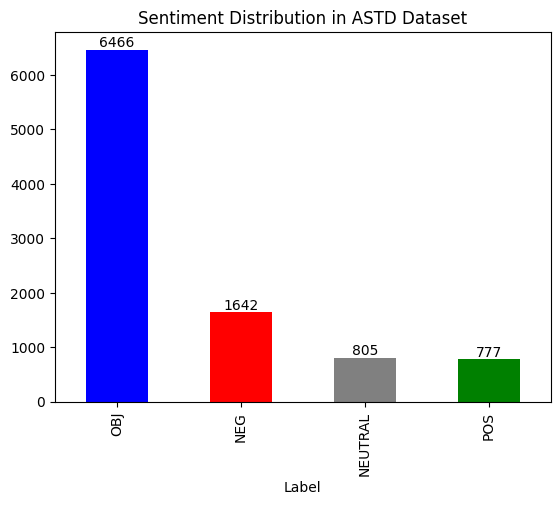

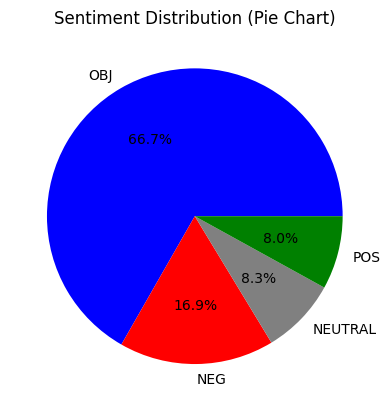

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Count sentiment occurrences
sentiment_counts = df["Label"].value_counts()
print("Sentiment Distribution:\n", sentiment_counts)

# Define colors for the 4 ratings
colors = ["blue", "red", "gray", "green"]

# Bar Chart
ax = sentiment_counts.plot(kind="bar", color=colors)
plt.title("Sentiment Distribution in ASTD Dataset")

# Add the exact number on top of each bar
for i, v in enumerate(sentiment_counts):
    ax.text(i, v + 0.05, str(v), ha='center', va='bottom', fontsize=10)  # Adjust vertical position if needed

#plt.savefig("bar_chart.png")
plt.show()

# Pie Chart
sentiment_counts.plot(kind="pie", autopct="%1.1f%%", colors=colors)
plt.title("Sentiment Distribution (Pie Chart)")
plt.ylabel("")
#plt.savefig("pie_chart.png")
print("\n")
plt.show()


In [ ]:
# Filter out OBJ and NEUTRAL sentiments
df = df[df["Label"].isin(["POS", "NEG"])]

# Print summary
print("New Sentiment Distribution:")
print(df["Label"].value_counts())

New Sentiment Distribution:
Label
NEG    1642
POS     777
Name: count, dtype: int64


Sentiment Distribution:
 Label
NEG    1642
POS     777
Name: count, dtype: int64


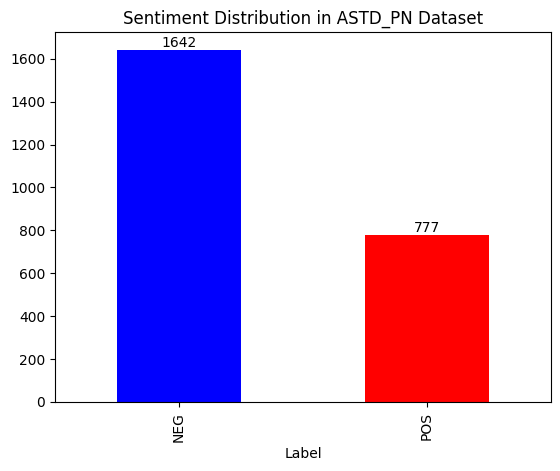

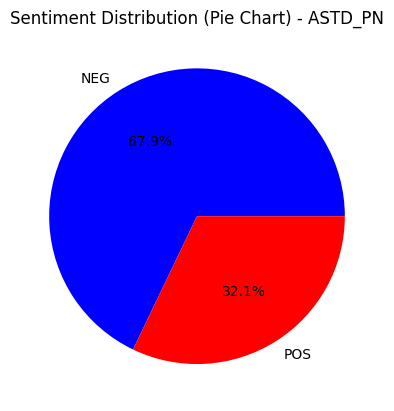

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset
#df = pd.read_csv("ASTD_PN.csv", encoding="utf-8")

# Count sentiment occurrences
sentiment_counts = df["Label"].value_counts()
print("Sentiment Distribution:\n", sentiment_counts)

# Define colors for the 2 ratings
colors = ["blue", "red"]

# Bar Chart
ax = sentiment_counts.plot(kind="bar", color=colors)
plt.title("Sentiment Distribution in ASTD_PN Dataset")

# Add the exact number on top of each bar
for i, v in enumerate(sentiment_counts):
    ax.text(i, v + 0.05, str(v), ha='center', va='bottom', fontsize=10)  # Adjust vertical position if needed

#plt.savefig("bar_chart_pn.png")
plt.show()

# Pie Chart
sentiment_counts.plot(kind="pie", autopct="%1.1f%%", colors=colors)
plt.title("Sentiment Distribution (Pie Chart) - ASTD_PN")
plt.ylabel("")
#plt.savefig("pie_chart_pn.png")
print("\n")
plt.show()


In [ ]:
# Replace POS with 1 and NEG with 0 in the 'Label' column
df["Label"] = df["Label"].replace({"POS": 1, "NEG": 0})

# Save the new dataset
df.to_csv("ASTD.csv", index=False, encoding="utf-8")

# Print the first few rows to verify
print("Updated dataset saved as ASTD.csv")


Updated dataset saved as ASTD.csv


<ipython-input-6-25cfcb4c7c90>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Label"] = df["Label"].replace({"POS": 1, "NEG": 0})


### **Pretraitement**

In [ ]:
import pandas as pd
import string
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.isri import ISRIStemmer
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def remove_non_arabic(text):
    if isinstance(text, str):
        return re.sub(r'[^\u0620-\u064A\s]', ' ', text)
    return ''

def tokenization(text):
    if isinstance(text, str):
        return re.findall(r'\S+', text)  # Matches sequences of non-space characters
    return []

def remove_arabic_stopwords(tokens):
    arabic_stopwords = set(stopwords.words("arabic"))  # Convert to set for faster lookup
    return [token for token in tokens if token not in arabic_stopwords]

def get_root(word, stemmer):
    if isinstance(word, str):
        return stemmer.stem(word)
    return word

def stemming_AR(tokens):
    stemmer = ISRIStemmer()
    return [get_root(token, stemmer) for token in tokens]

def rejoin_tokens(tokens):
    filtered_tokens = [token for token in tokens if isinstance(token, str) and token.strip()]
    return ' '.join(filtered_tokens)

In [ ]:
def ASTD_pretraitement(text):
    if isinstance(text, str):

        # Step 1: Remove non-arabic characters
        text = remove_non_arabic(text)

        # Step 2: Tokenization (split text into tokens)
        tokens = tokenization(text)

        # Step 3: Remove Arabic stopwords
        tokens = remove_arabic_stopwords(tokens)

        # Step 4: Apply stemming (ISRI Stemmer for Arabic)
        tokens = stemming_AR(tokens)

        # Step 5: Rejoin tokens into a single string
        return rejoin_tokens(tokens)

    return ''

In [ ]:
print(f"Start processing ASTD ...\n")
ASTD = pd.read_csv("/content/ASTD.csv")
ASTD["Text"] = [ASTD_pretraitement(text) for text in df["Text"]]
ASTD.to_csv("/content/ASTD_Pre.csv", index=False)
print(f"Finished processing ASTD!\n")

Start processing ASTD ...

Finished processing ASTD!



### **Balancing**

In [ ]:
from sklearn.utils import resample
import pandas as pd

# Load your original dataset
df = pd.read_csv('ASTD_Pre.csv', encoding='utf-8-sig')

# Drop NaNs
df = df.dropna(subset=['Text']).reset_index(drop=True)

# Separate classes
df_majority = df[df['Label'] == 1]
df_minority = df[df['Label'] == 0]

# Oversample minority
df_minority_oversampled = resample(df_minority,
                                   replace=True,
                                   n_samples=len(df_majority),
                                   random_state=42)

# Combine and shuffle
df_balanced = pd.concat([df_majority, df_minority_oversampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Save to CSV
df_balanced.to_csv('ASTD_Pre_Blc.csv', index=False, encoding='utf-8-sig')

print("Balanced text data saved to 'balanced_text_data.csv'")

Balanced text data saved to 'balanced_text_data.csv'
